In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import pandas as pd
from neuralprophet import NeuralProphet
import plotly.graph_objects as go
import pickle

In [20]:
df = pd.read_csv('./dataset/sensors_202205251324.csv')

df['created_at'] = pd.to_datetime(df['created_at'], unit='s')
df.set_index('created_at',inplace=True)

cols = ['temperature']
df = df[cols].astype(float)


In [21]:
df.head()

,temperature
created_at,
2022-05-18 07:55:58,34.0
2022-05-18 07:56:06,34.1
2022-05-18 07:56:15,34.1
2022-05-18 07:56:20,34.1
2022-05-18 07:56:26,34.1


In [22]:
freq = '1min'

In [23]:
df = df.resample(freq).mean().interpolate()

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9990 entries, 2022-05-18 07:55:00 to 2022-05-25 06:24:00
Freq: T
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  9990 non-null   float64
dtypes: float64(1)
memory usage: 156.1 KB


In [25]:
df = df.reset_index()

In [26]:
new_column = df[['created_at', 'temperature']] 
new_column.dropna(inplace=True)
new_column.columns = ['ds', 'y'] 

In [43]:
df_train, df_val = NeuralProphet().split_df(new_column, freq='1min', valid_p=0.2)

INFO - (NP.df_utils._infer_frequency) - Major frequency T corresponds to 99.99% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 1min


In [44]:
n = NeuralProphet(
    changepoints_range=0.95,
    n_changepoints=120,
    batch_size=32,
    learning_rate=0.2,
    weekly_seasonality=False,
    daily_seasonality=True
)
# n = NeuralProphet()
model = n.fit(df_train, validation_df=df_val, freq='1h')

INFO - (NP.df_utils._infer_frequency) - Major frequency T corresponds to 99.987% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency 1h is different than major frequency T
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 109
Epoch[109/109]: 100%|██████████| 109/109 [01:23<00:00,  1.31it/s, SmoothL1Loss=0.000399, MAE=0.185, RMSE=0.269, RegLoss=0, MAE_val=1.05, RMSE_val=1.2, SmoothL1Loss_val=0.00776] 


In [45]:
trace1 = go.Scatter(
    x = model.index,
    y = model['SmoothL1Loss'].values,
    mode = 'lines',
    name = 'SmoothL1Loss'
)
trace2 = go.Scatter(
    x = model.index,
    y = model['SmoothL1Loss_val'].values,
    mode = 'lines',
    name = 'SmoothL1Loss_val'
)
trace3 = go.Scatter(
    x = model.index,
    y = model['MAE'].values,
    mode = 'lines',
    name = 'MAE'
)
trace4 = go.Scatter(
    x = model.index,
    y = model['MAE_val'].values,
    mode = 'lines',
    name = 'MAE_val'
)

layout = go.Layout(
    title = "temp",
    xaxis = {'title' : "datetime"},
    yaxis = {'title' : "temperature"}
)
fig = go.Figure(data=[trace1, trace2,trace3,trace4], layout=layout)
fig.show()

In [46]:
future = n.make_future_dataframe(df_val, periods=24,n_historic_predictions=True)
forecast = n.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency T corresponds to 99.95% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency 1h is different than major frequency T
INFO - (NP.df_utils._infer_frequency) - Major frequency T corresponds to 98.764% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency 1h is different than major frequency T
INFO - (NP.df_utils._infer_frequency) - Major frequency T corresponds to 98.764% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency 1h is different than major frequency T


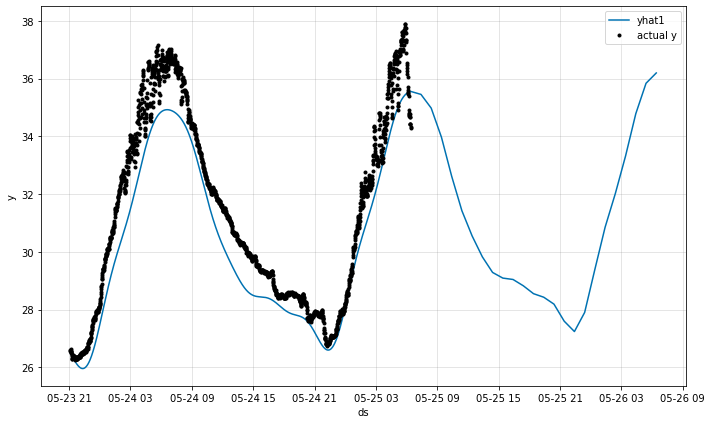

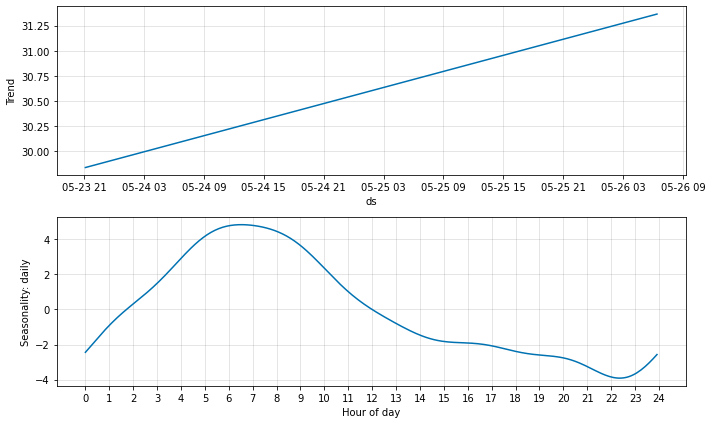

In [47]:
fig_forecast = n.plot(forecast)
fig_components = n.plot_components(forecast)

In [48]:
trace1 = go.Scatter(
    x = new_column['ds'].values,
    y = new_column['y'].values,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = forecast['ds'].values,
    y = forecast['yhat1'].values,
    mode = 'lines',
    name = 'Prediction'
)

layout = go.Layout(
    title = "temp",
    xaxis = {'title' : "datetime"},
    yaxis = {'title' : "temperature"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

In [49]:
with open('./models/neuralprophet_model.pkl', "wb") as f:
    pickle.dump(n, f)